Task 4: System calibration with X-rays
======================================

In this task you will take images with an <sup>55</sup>Fe X-ray source and use the signal to calibrate the response of the sensor and calculate the system gain.

**You will need an <sup>55</sup>Fe source that should be installed only by a workshop supervisor. Do not handle the source yourself.**

X-ray signals provide one of the best methods to calibrate the gain of a system, and it can also be used to measure the noise and the responsivity of an image sensor. The calibration links the displayed output in ADC units (ADU) to physical units of electrons deposited in the sensor.

A radioactive isotope of iron (<sup>55</sup>Fe) emits X-rays with energies of 5,898 eV (Mn-Kɑ) and 6,490 eV (Mn-Kβ) in its decay into manganese (<sup>55</sup>Mn). The X-rays generate well known electron charge in silicon and this is used for the calibration. By generating a histogram of the pixel signals, similar to the one shown in Figure 9, the correspondence between ADC channel and signal charge can be determined from the difference between the X-day signal peak and the noise peak (corresponding to pixels with no X-ray charge).

![55Fe histogram](images/55Fe-histogram.png)

Figure – Example histogram of X-ray events from a <sup>55</sup>Fe source.

Tasks
-----

1. Restore the system to normal operation using the CR_2.cfg pixel timing, deselect C_ADDR_EN Override (and upload configuration). Set the rows and the columns for full sensor readout and turn off the LED.

2. Ask the supervisor to mount the 55Fe source on top of the sensor with the glass cover removed. Cover the metal box with the blackout cloth to prevent light leaks.

3. Take images and adjust the readout rows to cover the area over which the X-ray source is mounted. You can increase the timer period in order to increase the number of X-ray events per image.

4. In the File tab (Figure 10) press WRITING and select the number of consecutive images to save in Images to Save before pressing Acquire to take them. The number of required images should be at least two more than the Images to Save.

5. Save about 20 or more images in your own directory to make sure that you have sufficient number of X-ray events. Only the ROI is saved to file, and the images are appended in the same file until the file name is changed. Bear in mind that one full image is 5.8 Mbytes.

6. After saving enough images with X-ray illumination, ask the supervisor to remove the source and take 10 images in darkness. The averaged dark frame will be used for offline subtraction of pixel offsets and hot pixels. Alternatively, the median pixel signal with X-rays can be used as a *dark* image.

7. Start Octave GUI and run a copy of the script CIS115_Xray_Calibration.m from C:\CIS\Scripts\ to produce a histogram and determine:

    a) The distance between the X-ray signal peak and the noise peak in ADU

    b) The system gain 𝐾 in e-/ADU

8. Save the spectrum as an image or as a plot.

9. Verify that the noise peak is at approximately 0 ADU.

Note
----

From Book page 38...

X-rays of low energy (<20 keV for silicon) provide absolute system calibration because the photogenerated electron signal is well known. For example, the widely used radioactive isotope of iron <sup>55</sup>Fe produces characteristic X-ray photons of 5898 eV and 6490 eV from its decay into manganese <sup>55</sup>Mn. Each absorbed X-ray creates a welldefined electron signal with size obtained from the ionisation energy needed to generate one electron-hole pair in silicon, which at **273 K is 3.65 eV**. The Mn-Kβ 6490 eV photon has 12% relative intensity of the dominant Mn-Kα 5898 eV photon, and in noisy systems they may not be resolvable and could appear as a single X-ray signal.

Arguments
---------


In [1]:
data_dir = r"/Users/hans.smit/work/CMOS-course-20251001/tasks/task4/data/"
dark_img_pth = f"{data_dir}dark.img"
xray_img_pth = f"{data_dir}xray.img"

Computation
-----------

In [2]:
%matplotlib ipympl

In [3]:
from cis_tools import utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [4]:
imgs_dark = utils.extract_images(dark_img_pth)

In [5]:
dark_img = np.mean(imgs_dark, 0)

In [6]:
imgs_xray = utils.extract_images(xray_img_pth)

In [7]:
xrays = (imgs_xray - dark_img).reshape(-1)

In [8]:
bins = np.arange(-200,2000,5)

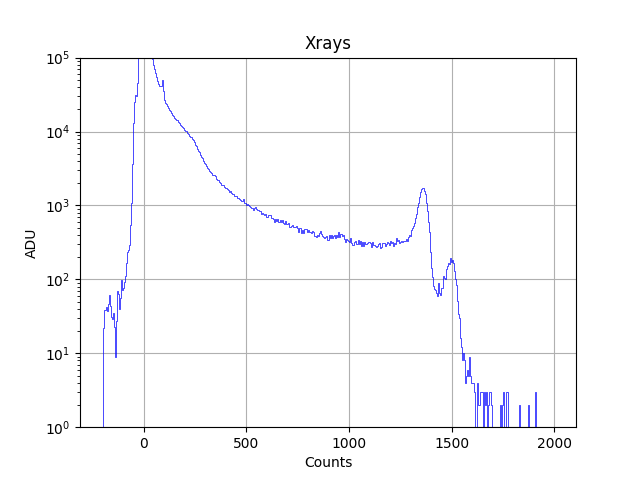

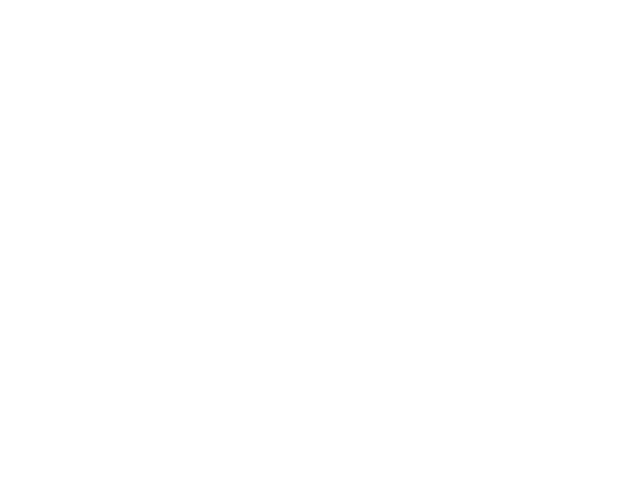

In [9]:
plt.clf()
fig, ax = plt.subplots()
hist_data = ax.hist(xrays, bins=bins, histtype='step', color='blue', linewidth=0.5)
ax.set_title("Xrays")
ax.set_xlabel("Counts")
ax.set_ylabel("ADU")
ax.set_yscale('log')
ax.set_ylim(1, 100000)
ax.grid()
plt.show()

Optional step
-------------

Smoothing histogram plot and peak finding using scipy.

In [10]:
y, x, _ = hist_data
#x = x[1:]  # remove a point to match y

In [11]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode="same")
    return y_smooth

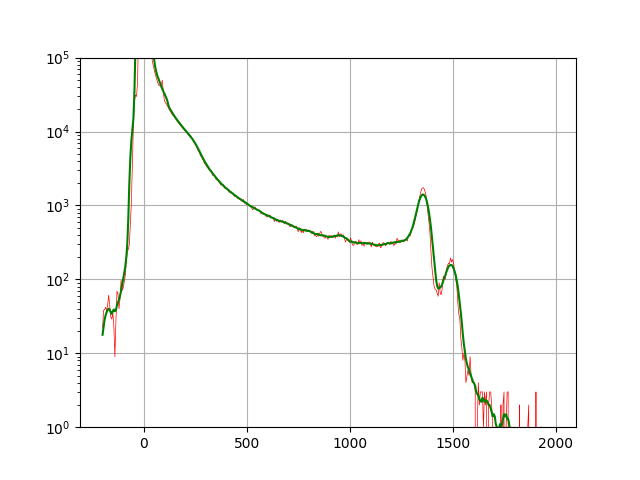

In [12]:
yhat = smooth(y, 10)
# plt.clf()
#plt.plot(x, y, color='red')
fig, ax = plt.subplots()
ax.plot(x[:-1], y, color="red", linewidth=0.5)
ax.plot(x[:-1], yhat, color="green")
ax.set_yscale('log')
ax.set_ylim(1, 100000)
ax.grid()
plt.show()

In [13]:
x_peak_loc, props = find_peaks(yhat, width=50, rel_height=50, height=[50, 10000])

In [14]:
x_peak_loc

array([311, 339])

In [15]:
y[x_peak_loc]

array([1725.,  172.])

In [16]:
x[x_peak_loc]

array([1355., 1495.])

In [17]:
props

{'peak_heights': array([1406.4,  156.4]),
 'prominences': array([1118.4,   81.1]),
 'left_bases': array([268, 326]),
 'right_bases': array([400, 400]),
 'widths': array([132.,  74.]),
 'width_heights': array([-54513.6,  -3898.6]),
 'left_ips': array([268., 326.]),
 'right_ips': array([400., 400.])}

Results
-------

In [18]:
Ei = 3.65 # [eV/e-] taken as constant from book
noise_peak = -3.0  # ADU
xray_peak1 = 1358.2  # ADU @ Mn-Kα 5898 eV
xray_peak2 = 1490.0  # ADU @ Mn-Kβ 6490 eV

In [19]:
K1 = 5898 / (xray_peak1 - noise_peak)
print(K1)

4.332941522186306


In [20]:
K2 = 6490 / (xray_peak2 - noise_peak)
print(K2)

4.34695244474213


In [21]:
K = (K1 + K2) / 2
print(K)

4.339946983464218


In [22]:
Ke = K1 / Ei
print(Ke)

1.1871072663524125


Summary
-------

In [23]:
print(f"System Gain in eV: {K:0.4} eV/ADU @ (Mn-Kα + Mn-Kβ) / 2")

System Gain in eV: 4.34 eV/ADU @ (Mn-Kα + Mn-Kβ) / 2


In [24]:
e_ = "e\u207b"  # formatted electron symbol
print(f"Ionisation Energy to generate one electron-hole pair for Silcon at 273K is {Ei} eV/{e_}")

Ionisation Energy to generate one electron-hole pair for Silcon at 273K is 3.65 eV/e⁻


In [25]:
print(f"System Gain in electrons: {Ke:0.4} {e_}/ADU @ Mn-Kα")

System Gain in electrons: 1.187 e⁻/ADU @ Mn-Kα
